In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf 
from matplotlib import pyplot as plt
import pickle
from PIL import Image
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Lambda, Dense, Flatten, Input
from keras.models import Model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

import os

2023-04-20 11:33:45.665041: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
#ds_path = '/kaggle/input/utkface-new/UTKFace/'
ds_path= '/Users/elenarodriguez/Documents/Escuela/4to/ML/Proyecto/Dataset/UTKFace/UTKFace/'

In [20]:
for dirname, _, filenames in os.walk(ds_path):
    for filename in filenames:
        splitted = filename.split('_')
        age = splitted[0]
        gender = splitted[1]
        race = splitted[2]
        print(os.path.join(dirname, filename))
        break

/Users/elenarodriguez/Documents/Escuela/4to/ML/Proyecto/Dataset/UTKFace/UTKFace/9_1_2_20161219204347420.jpg.chip.jpg


In [21]:
df = pd.DataFrame(filenames, columns = ['filename'] )
df['filepath'] = df.filename.apply(lambda x: ds_path + x )
df['age'] = df.filename.apply(lambda x: int(x.split('_')[0]))
df['gender'] = df.filename.apply(lambda x: int(x.split('_')[1]))
df['race'] = df.filename.apply(lambda x: int(x.split('_')[-2]))

In [22]:
IMG_WIDTH, IMG_HEIGHT = 96, 96
race_mapper = {0:'white', 1:'black',2: 'asian',3: 'indian', 4:'other'}
gender_mapper = {0:'male',1:'female'}
df.head()

,filename,filepath,age,gender,race
0,9_1_2_20161219204347420.jpg.chip.jpg,/Users/elenarodriguez/Documents/Escuela/4to/ML...,9,1,2
1,36_0_1_20170117163203851.jpg.chip.jpg,/Users/elenarodriguez/Documents/Escuela/4to/ML...,36,0,1
2,86_1_0_20170120225751953.jpg.chip.jpg,/Users/elenarodriguez/Documents/Escuela/4to/ML...,86,1,0
3,26_1_0_20170116171048641.jpg.chip.jpg,/Users/elenarodriguez/Documents/Escuela/4to/ML...,26,1,0
4,1_1_2_20161219154612988.jpg.chip.jpg,/Users/elenarodriguez/Documents/Escuela/4to/ML...,1,1,2


In [23]:
df.describe()

,age,gender,race
count,23708.000000,23708.000000,23708.000000
mean,33.303484,0.477349,1.269192
std,19.886112,0.499497,1.345556
min,1.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000
50%,29.000000,0.000000,1.000000
75%,45.000000,1.000000,2.000000
max,116.000000,1.000000,4.000000


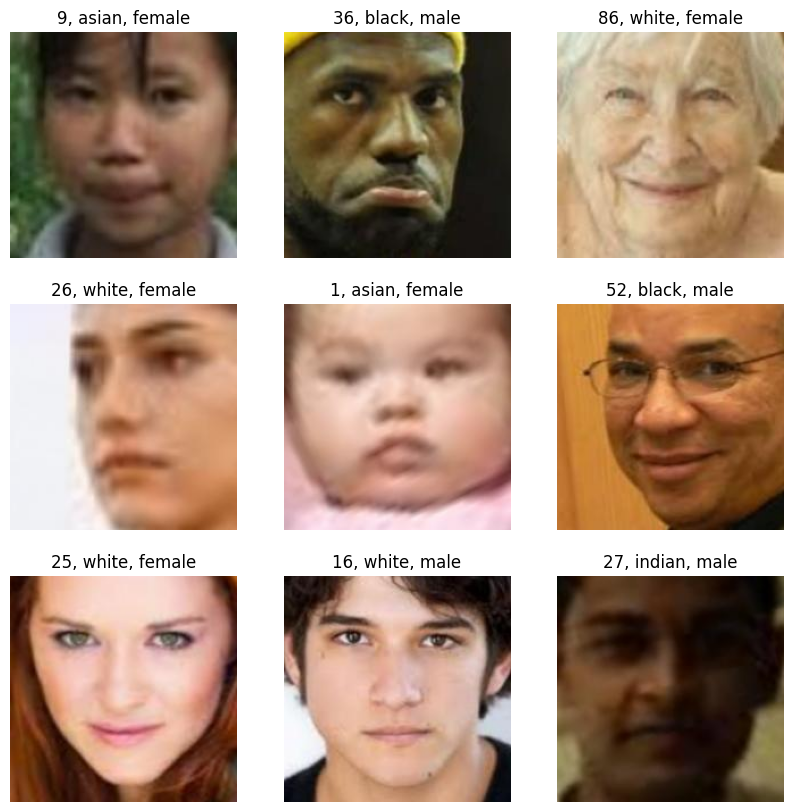

In [25]:
plt.figure(figsize=(10,10))
for i in range(9):
    sample = df.loc[i]
    plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.title('%i, %s, %s' % (sample.age,race_mapper[sample.race],gender_mapper[sample.gender]))
    plt.imshow(Image.open(ds_path + sample.filename))

In [26]:
def feature_extract( inputs):
    l1 = inputs
    l2 = Conv2D(64, (3,3), padding='same', activation='relu')(l1)
    l3 = Conv2D(64, (3,3), padding='same', activation='relu')(l2)
    l4 = MaxPooling2D((2,2), strides=(2,2))(l3)
    l5 = Conv2D(128, (3,3), padding='same', activation='relu')(l4)
    l6 = Conv2D(128, (3,3), padding='same', activation='relu')(l5)
    l7 = MaxPooling2D((2,2), strides=(2,2))(l6)
    l8 = Conv2D(256, (3,3), padding='same', activation='relu')(l7)
    l9 = Conv2D(256, (3,3), padding='same', activation='relu')(l8)
    l10 = Conv2D(256, (3,3), padding='same', activation='relu')(l9)
    l11 = MaxPooling2D((2,2), strides=(2,2))(l10)
    l12 = Conv2D(512, (3,3), padding='same', activation='relu')(l11)
    l13 = Conv2D(512, (3,3), padding='same', activation='relu')(l12)
    l15 = Conv2D(512, (3,3), padding='same', activation='relu')(l13)
    l16 = MaxPooling2D((2,2), strides=(2,2))(l15)
    l17 = Conv2D(512, (3,3), padding='same', activation='relu')(l16)
    l18 = Conv2D(512, (3,3), padding='same', activation='relu')(l17)
    l19 = Conv2D(512, (3,3), padding='same', activation='relu')(l18)
    l20 = MaxPooling2D((2,2), strides=(2,2))(l19)
    return l20

def age_branch( inputs):
    l1 = tf.keras.layers.Flatten()(inputs)
    l2 = tf.keras.layers.Dense(256, activation='relu')(l1)
    l3 = tf.keras.layers.Dense(256, activation='relu')(l2)
    l4 = tf.keras.layers.Dense(1, activation='linear', name="age_output")(l3)
    return l4

def gender_branch( inputs, num_genders=2):
    l1 = tf.keras.layers.Flatten()(inputs)
    l2 = tf.keras.layers.Dense(128, activation='relu')(l1)
    l3 = tf.keras.layers.Dense(64, activation='relu')(l2)
    l4 = tf.keras.layers.Dense(num_genders, activation='softmax', name="gender_output")(l3)
    return l4

def race_branch( inputs, num_races):
    l1 = tf.keras.layers.Flatten()(inputs)
    l2 = tf.keras.layers.Dense(128, activation='relu')(l1)
    l3 = tf.keras.layers.Dense(64, activation='relu')(l2)
    l4 = tf.keras.layers.Dense(num_races, activation='softmax', name="race_output")(l3)
    return l4

def full_model( width, height, num_races):
    input_shape = (height, width, 3)
    inputs = tf.keras.layers.Input(shape=input_shape)
    feature_extractor = feature_extract(inputs)
    age_output = age_branch(feature_extractor)
    gender_output = gender_branch(feature_extractor)
    race_output = race_branch(feature_extractor, num_races)
    model = tf.keras.Model(inputs=inputs,
                  outputs=[age_output, race_output, gender_output],
                  name="utk_face_net")
    return model

In [27]:
model = full_model(IMG_WIDTH,IMG_HEIGHT, len(race_mapper))

In [28]:
model.summary()
plot_model(model)

Model: "utk_face_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 96, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 48, 64)   0           ['conv2d_1[0][0]']               
                                                                                       

In [29]:
opt = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss={
                  'age_output': 'mse',
                  'race_output': 'categorical_crossentropy',
                  'gender_output': 'binary_crossentropy'},

              metrics={
                  'age_output': 'mae',
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

In [70]:
df['filepath']

0        /Users/elenarodriguez/Documents/Escuela/4to/ML...
1        /Users/elenarodriguez/Documents/Escuela/4to/ML...
2        /Users/elenarodriguez/Documents/Escuela/4to/ML...
3        /Users/elenarodriguez/Documents/Escuela/4to/ML...
4        /Users/elenarodriguez/Documents/Escuela/4to/ML...
                               ...                        
23703    /Users/elenarodriguez/Documents/Escuela/4to/ML...
23704    /Users/elenarodriguez/Documents/Escuela/4to/ML...
23705    /Users/elenarodriguez/Documents/Escuela/4to/ML...
23706    /Users/elenarodriguez/Documents/Escuela/4to/ML...
23707    /Users/elenarodriguez/Documents/Escuela/4to/ML...
Name: filepath, Length: 23708, dtype: object

In [124]:
count = 10000
data_xx = df['filepath'].iloc[10000:10000+count].to_numpy()
#.map(lambda x: .to_numpy(index=False)
 
data_yy = df[['age','gender','race']].iloc[10000:10000+count].to_records(index=False)

In [125]:
data_yy

rec.array([(48, 1, 0), (26, 0, 0), (47, 1, 0), ..., (39, 0, 2),
           (25, 1, 1), (11, 1, 0)],
          dtype=[('age', '<i8'), ('gender', '<i8'), ('race', '<i8')])

In [137]:
data_x_test_1= df['filepath'].iloc[:10000].to_numpy()
data_x_test_2= df['filepath'].iloc[10000+count:].to_numpy()
data_x_test= np.concatenate((data_x_test_1,data_x_test_1), axis=None)

data_y_test_1= df[['age','gender','race']].iloc[:10000].to_records(index=False)
data_y_test_2= df[['age','gender','race']].iloc[10000+count:].to_records(index=False)
data_y_test= np.concatenate((data_y_test_1,data_y_test_1), axis=None )

In [108]:
def proccess_data(data_x, data_y):
    images = []
    ages = []
    races = []
    genders = []
    for i in range(len(data_x)):
        img = np.array(Image.open(data_x[i]).resize((IMG_WIDTH,IMG_HEIGHT))) / 255.
        images.append(img)
        ages.append(data_y[i][0] / 116.)
        races.append(to_categorical(data_y[i][2], len(race_mapper)))
        genders.append(to_categorical(data_y[i][1], len(gender_mapper)))

    images = np.array(images)
    return images, ages,races,genders

In [109]:
# Processing data 
images,ages,races,genders= proccess_data(data_xx,data_yy)

In [138]:
images_test,ages_test,races_test,genders_test= proccess_data(data_x_test, data_y_test)

In [141]:
images_train, images_val, ages_train,ages_val, races_train,races_val,genders_train,genders_val  = train_test_split(images, np.array(ages),np.array(races),np.array(genders),test_size=0.15)

In [139]:
len(images_train)

8500

In [142]:
len(images_val)

1500

In [143]:
len(images_test)

20000

In [144]:
train_y = [ages_train,races_train,genders_train]
val_y =  [ages_test,races_test,genders_test]

In [34]:
history = model.fit(images_train,train_y, validation_data=(images_val,val_y),  epochs=10  )

Epoch 1/10
266/266 [==============================] - 1788s 7s/step - loss: 2.1780 - age_output_loss: 0.0386 - race_output_loss: 1.4467 - gender_output_loss: 0.6927 - age_output_mae: 0.1519 - race_output_accuracy: 0.4251 - gender_output_accuracy: 0.5241 - val_loss: 2.1305 - val_age_output_loss: 0.0346 - val_race_output_loss: 1.4046 - val_gender_output_loss: 0.6913 - val_age_output_mae: 0.1439 - val_race_output_accuracy: 0.4293 - val_gender_output_accuracy: 0.5167
Epoch 2/10
266/266 [==============================] - 1556s 6s/step - loss: 1.9320 - age_output_loss: 0.0314 - race_output_loss: 1.2910 - gender_output_loss: 0.6096 - age_output_mae: 0.1359 - race_output_accuracy: 0.5001 - gender_output_accuracy: 0.6520 - val_loss: 1.6848 - val_age_output_loss: 0.0249 - val_race_output_loss: 1.1490 - val_gender_output_loss: 0.5109 - val_age_output_mae: 0.1232 - val_race_output_accuracy: 0.5640 - val_gender_output_accuracy: 0.7480
Epoch 3/10
266/266 [==============================] - 1550s 6s/s

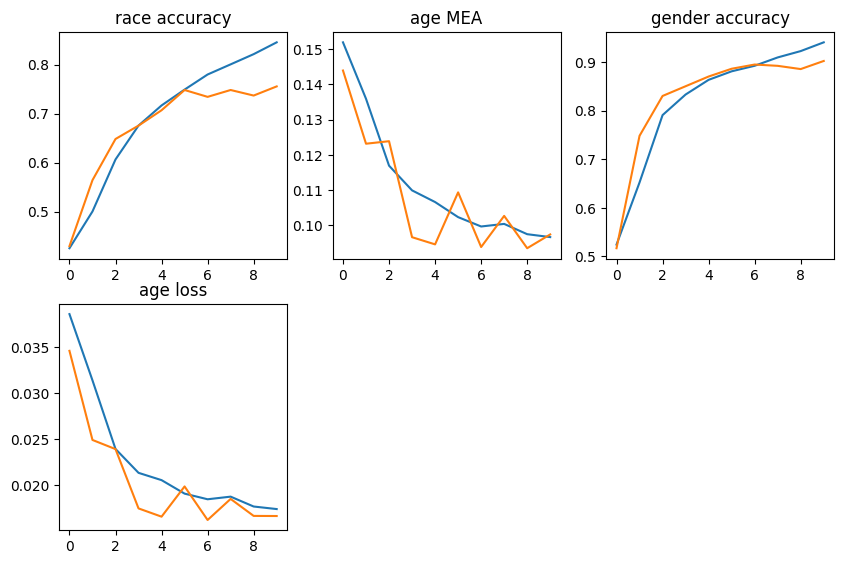

In [35]:
plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
plt.title('race accuracy')
plt.plot(range(10), history.history['race_output_accuracy'],history.history['val_race_output_accuracy'])

plt.subplot(3,3,2)
plt.title('age MEA')
plt.plot(range(10), history.history['age_output_mae'],history.history['val_age_output_mae'])

plt.subplot(3,3,3)
plt.title('gender accuracy')
plt.plot(range(10), history.history['gender_output_accuracy'],history.history['val_gender_output_accuracy'])


plt.subplot(3,3,4)
plt.title('age loss')
plt.plot(range(10), history.history['age_output_loss'],history.history['val_age_output_loss'])

In [156]:
model.evaluate(images_test[:1000], [np.array(ages_test[:1000]),np.array(races_test[:1000]),np.array(genders_test[:1000])])

32/32 [==============================] - 86s 3s/step - loss: 1.1362 - age_output_loss: 0.0162 - race_output_loss: 0.7462 - gender_output_loss: 0.3738 - age_output_mae: 0.0985 - race_output_accuracy: 0.7570 - gender_output_accuracy: 0.8600


[1.136225700378418,
 0.016229795292019844,
 0.7462149858474731,
 0.37378063797950745,
 0.09847096353769302,
 0.7570000290870667,
 0.8600000143051147]

In [161]:
predict= model.predict(images_test[:10])

1/1 [==============================] - 1s 804ms/step
 Predict 28, asian, female
 Predict 39, black, male
 Predict 47, white, female
 Predict 30, indian, female
 Predict 25, black, male
 Predict 63, black, male
 Predict 32, white, female
 Predict 30, white, male
 Predict 40, indian, male
 Predict 31, indian, female


In [178]:
pred_result= pd.DataFrame()
pred_result['image_path']= data_x_test[:10]

In [179]:
predicted_age=[]
predicted_gender=[]
predicted_race=[]
for i in range(10):
    predicted_age.append(int(predict[0][i] * 116))
    predicted_race.append(race_mapper[np.argmax(predict[1][i])])
    predicted_gender.append(gender_mapper[np.argmax(predict[2][i])])
pred_result['pred_age']= predicted_age
pred_result['pred_gender']= predicted_gender
pred_result['pred_race']= predicted_race
pred_result['real_age']= np.concatenate((df['age'].iloc[:10000].to_numpy(), df['age'].iloc[10000+count:].to_numpy()))
pred_result['real_gender']= np.concatenate((df['gender'].iloc[:10000].to_numpy(), df['gender'].iloc[10000+count:].to_numpy()))
pred_result['real_race']= np.concatenate((df['race'].iloc[:10000].to_numpy(), df['race'].iloc[10000+count:].to_numpy()))

In [180]:
pred_result

,image_path,pred_age,pred_gender,pred_race
0,/Users/elenarodriguez/Documents/Escuela/4to/ML...,28,female,asian
1,/Users/elenarodriguez/Documents/Escuela/4to/ML...,39,male,black
2,/Users/elenarodriguez/Documents/Escuela/4to/ML...,47,female,white
3,/Users/elenarodriguez/Documents/Escuela/4to/ML...,30,female,indian
4,/Users/elenarodriguez/Documents/Escuela/4to/ML...,25,male,black
5,/Users/elenarodriguez/Documents/Escuela/4to/ML...,63,male,black
6,/Users/elenarodriguez/Documents/Escuela/4to/ML...,32,female,white
7,/Users/elenarodriguez/Documents/Escuela/4to/ML...,30,male,white
8,/Users/elenarodriguez/Documents/Escuela/4to/ML...,40,male,indian
9,/Users/elenarodriguez/Documents/Escuela/4to/ML...,31,female,indian


In [166]:
predict

[array([[0.24221808],
        [0.3447449 ],
        [0.40939492],
        [0.26115546],
        [0.216456  ],
        [0.5452107 ],
        [0.28230235],
        [0.26547876],
        [0.3506151 ],
        [0.27281943]], dtype=float32),
 array([[6.77026995e-03, 9.28552151e-02, 8.76432240e-01, 1.14708592e-03,
         2.27951668e-02],
        [2.35162284e-02, 9.62868035e-01, 5.60464396e-04, 1.01591963e-02,
         2.89601972e-03],
        [9.37284052e-01, 1.33519084e-03, 4.97578271e-02, 1.29770779e-03,
         1.03251897e-02],
        [1.86112583e-01, 2.76825819e-02, 6.82246536e-02, 5.59519589e-01,
         1.58460513e-01],
        [2.28743330e-01, 4.07653511e-01, 1.86622515e-02, 1.28445074e-01,
         2.16495752e-01],
        [1.04513675e-01, 7.30057061e-01, 1.83179677e-02, 1.17064364e-01,
         3.00469529e-02],
        [9.69700217e-01, 2.48663302e-04, 1.28612295e-03, 2.76493304e-03,
         2.59998739e-02],
        [7.36374021e-01, 6.88241154e-04, 2.04484776e-01, 2.64756270e-0

1/1 [==============================] - 0s 102ms/step


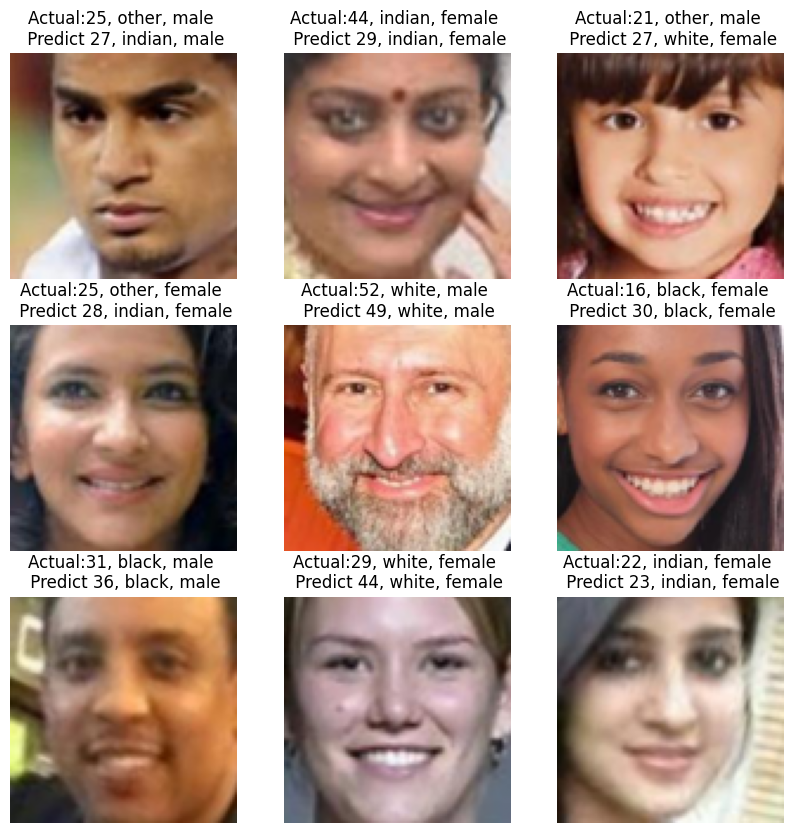

In [153]:
# Ejemplo para visualizar la prediccion
plt.figure(figsize=(10,10))
for i in range(9):
    sample = df.loc[i+250]
    img = np.array(Image.open(sample.filepath).resize((IMG_WIDTH,IMG_HEIGHT)) ) / 255.
    predict = model.predict(np.array([img])) 
    plt.subplot(3,3,i+1)
    age = int(predict[0] * 116)
    race = race_mapper[np.argmax(predict[1])]
    gender = gender_mapper[np.argmax(predict[2])]
    plt.axis('off')
    plt.title('Actual:%i, %s, %s \n Predict %i, %s, %s' % (sample.age,race_mapper[sample.race],gender_mapper[sample.gender], age, race, gender))
    plt.imshow(img) 

In [37]:
model.save('model.h5')